In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    
    # Separate cats (3) and dogs (5)
    cat_mask = torch.tensor([label == 3 for label in dataset.targets])
    dog_mask = torch.tensor([label == 5 for label in dataset.targets])
    
    cat_data = dataset.data[cat_mask]
    dog_data = dataset.data[dog_mask]
    
    cat_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(cat_data).permute(0, 3, 1, 2) / 127.5 - 1)
    dog_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(dog_data).permute(0, 3, 1, 2) / 127.5 - 1)
    
    return (torch.utils.data.DataLoader(cat_dataset, batch_size=64, shuffle=True),
            torch.utils.data.DataLoader(dog_dataset, batch_size=64, shuffle=True))

In [22]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 4*4*512),
            nn.Unflatten(1, (512, 4, 4)),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.main(x)


In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)


In [24]:
class AnimalGAN:
    def __init__(self):
        self.latent_dim = 100
        self.cat_generator = Generator(self.latent_dim).to(device)
        self.dog_generator = Generator(self.latent_dim).to(device)
        self.cat_discriminator = Discriminator().to(device)
        self.dog_discriminator = Discriminator().to(device)
        
        self.g_optimizer_cat = optim.Adam(self.cat_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.d_optimizer_cat = optim.Adam(self.cat_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.g_optimizer_dog = optim.Adam(self.dog_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.d_optimizer_dog = optim.Adam(self.dog_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        
        self.criterion = nn.BCELoss()

    def train_step(self, real_images, generator, discriminator, g_optimizer, d_optimizer, animal_type):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Train Discriminator
        d_optimizer.zero_grad()
        noise = torch.randn(batch_size, self.latent_dim).to(device)
        fake_images = generator(noise)
        
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images.detach())
        
        d_loss = (self.criterion(real_output, torch.ones_like(real_output)) + 
                 self.criterion(fake_output, torch.zeros_like(fake_output)))
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = self.criterion(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        g_optimizer.step()
        
        return {'d_loss': d_loss.item(), 'g_loss': g_loss.item()}

    def generate_images(self, num_images=16, animal_type='cat'):
        generator = self.cat_generator if animal_type == 'cat' else self.dog_generator
        with torch.no_grad():
            noise = torch.randn(num_images, self.latent_dim).to(device)
            generated_images = generator(noise).cpu()
            generated_images = (generated_images + 1) / 2
            
            plt.figure(figsize=(4, 4))
            for i in range(num_images):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated_images[i].permute(1, 2, 0))
                plt.axis('off')
            plt.savefig(f'generated_{animal_type}s_500.png')
            plt.close()


In [25]:
def train_and_generate(catLoss,dogLoss):
    cat_loader, dog_loader = load_data()
    model = AnimalGAN()
    
    for epoch in range(500):
        # Combine both dataloaders using zip_longest and None padding
        from itertools import zip_longest
        for i, (cat_batch, dog_batch) in enumerate(zip_longest(cat_loader, dog_loader)):
            if cat_batch is not None:
                cat_metrics = model.train_step(cat_batch[0], model.cat_generator, 
                                            model.cat_discriminator, model.g_optimizer_cat, 
                                            model.d_optimizer_cat, 'cat')
            
            if dog_batch is not None:
                dog_metrics = model.train_step(dog_batch[0], model.dog_generator, 
                                            model.dog_discriminator, model.g_optimizer_dog, 
                                            model.d_optimizer_dog, 'dog')
            
            if epoch % 10 == 0 and i == 0:
                print(f"Epoch {epoch}")
                if cat_batch is not None:
                    print(f"Cat - D Loss: {cat_metrics['d_loss']:.4f}, G Loss: {cat_metrics['g_loss']:.4f}")
                    catLoss.append(f"Cat - D Loss: {cat_metrics['d_loss']:.4f}, G Loss: {cat_metrics['g_loss']:.4f}")
                if dog_batch is not None:
                    print(f"Dog - D Loss: {dog_metrics['d_loss']:.4f}, G Loss: {dog_metrics['g_loss']:.4f}")
                    dogLoss.append(f"Dog - D Loss: {dog_metrics['d_loss']:.4f}, G Loss: {dog_metrics['g_loss']:.4f}")
    
    # Generate both cats and dogs
    model.generate_images(num_images=16, animal_type='cat')
    model.generate_images(num_images=16, animal_type='dog')
    
    torch.save(model.cat_generator.state_dict(), 'cat_generator500.pth')
    torch.save(model.cat_discriminator.state_dict(), 'cat_discriminator500.pth')
    torch.save(model.dog_generator.state_dict(), 'dog_generator500.pth')
    torch.save(model.dog_discriminator.state_dict(), 'dog_discriminator500.pth')
    
    return model


In [26]:
catLoss = []
dogLoss = []
model = train_and_generate(catLoss,dogLoss)

Files already downloaded and verified
Epoch 0
Cat - D Loss: 1.4701, G Loss: 0.9337
Dog - D Loss: 1.4723, G Loss: 0.9804
Epoch 10
Cat - D Loss: 1.4061, G Loss: 0.8971
Dog - D Loss: 1.3199, G Loss: 0.9311
Epoch 20
Cat - D Loss: 1.3738, G Loss: 0.7916
Dog - D Loss: 1.5359, G Loss: 0.7310
Epoch 30
Cat - D Loss: 1.3789, G Loss: 0.7623
Dog - D Loss: 1.3137, G Loss: 0.9048
Epoch 40
Cat - D Loss: 1.4004, G Loss: 0.9476
Dog - D Loss: 1.4603, G Loss: 0.8743
Epoch 50
Cat - D Loss: 1.2957, G Loss: 0.8924
Dog - D Loss: 1.2465, G Loss: 1.0355
Epoch 60
Cat - D Loss: 1.2529, G Loss: 0.9155
Dog - D Loss: 1.3388, G Loss: 0.9155
Epoch 70
Cat - D Loss: 1.2688, G Loss: 1.0984
Dog - D Loss: 1.3129, G Loss: 1.1210
Epoch 80
Cat - D Loss: 1.1982, G Loss: 1.0664
Dog - D Loss: 1.2236, G Loss: 1.2776
Epoch 90
Cat - D Loss: 1.4406, G Loss: 1.5777
Dog - D Loss: 0.9607, G Loss: 1.6157
Epoch 100
Cat - D Loss: 1.0691, G Loss: 1.6922
Dog - D Loss: 2.0998, G Loss: 2.3605
Epoch 110
Cat - D Loss: 0.9360, G Loss: 1.7239
Do

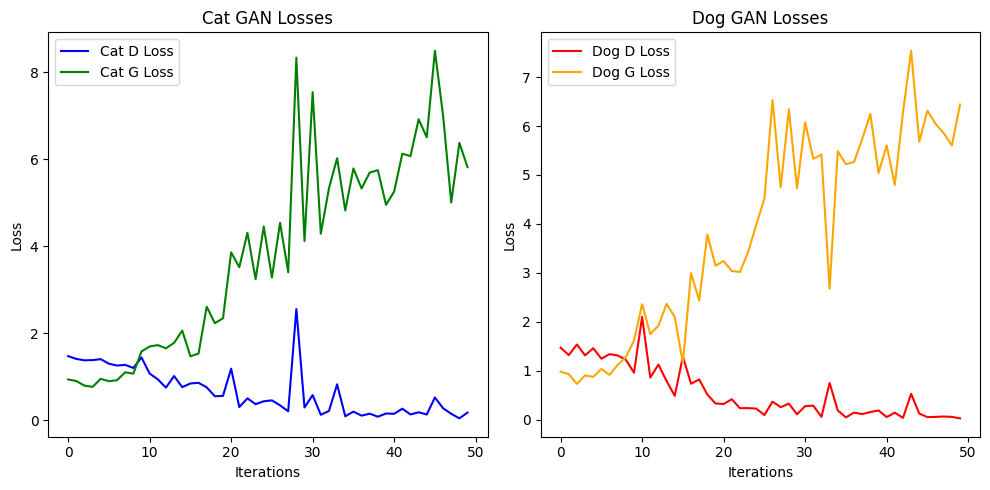

In [27]:
import matplotlib.pyplot as plt

# Extract losses from the logs
cat_d_losses = [float(loss.split('D Loss: ')[1].split(', G Loss')[0]) for loss in catLoss]
cat_g_losses = [float(loss.split('G Loss: ')[1]) for loss in catLoss]

dog_d_losses = [float(loss.split('D Loss: ')[1].split(', G Loss')[0]) for loss in dogLoss]
dog_g_losses = [float(loss.split('G Loss: ')[1]) for loss in dogLoss]

# Plot the losses
plt.figure(figsize=(10, 5))

# Cat losses
plt.subplot(1, 2, 1)
plt.plot(cat_d_losses, label='Cat D Loss', color='blue')
plt.plot(cat_g_losses, label='Cat G Loss', color='green')
plt.title("Cat GAN Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

# Dog losses
plt.subplot(1, 2, 2)
plt.plot(dog_d_losses, label='Dog D Loss', color='red')
plt.plot(dog_g_losses, label='Dog G Loss', color='orange')
plt.title("Dog GAN Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
